Importando as bibliotecas necessárias

In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pycircular as pycircular
from scipy.stats import chi2_contingency
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
LE = preprocessing.LabelEncoder()
from scipy.stats import f_oneway
from scipy.stats import ttest_ind
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

pd.set_option('display.max_columns', None)

Unindo os dataframes

In [2]:
df_channels = pd.read_csv(r'bases\channels.csv')
df_deliveries = pd.read_csv(r'bases\deliveries.csv')
df_drivers = pd.read_csv(r'bases\drivers.csv')
df_hubs = pd.read_csv(r'bases\hubs.csv')
df_orders = pd.read_csv(r'bases\orders.csv')
df_stores = pd.read_csv(r'bases\stores.csv')
df_payments = pd.read_csv(r'bases\payments.csv')

df = pd.merge(df_orders, df_stores, on='store_id')
df = pd.merge(df, df_hubs, on='hub_id')
df = pd.merge(df, df_channels, on='channel_id')
df = pd.merge(df, df_payments, on='payment_order_id')
df = pd.merge(df, df_deliveries, on='delivery_order_id')
df = pd.merge(df, df_drivers, on='driver_id')

In [1]:
df.describe().T

NameError: name 'df' is not defined

# Limpeza Inicial

In [4]:
grupo_pagamento = {
'DEBIT': 'CARD',
'CREDIT': 'CARD',
'DEBIT_STORE': 'CARD',
'CREDIT_STORE': 'CARD',
'INSTALLMENT_CREDIT_STORE': 'CARD',
'MEAL_BENEFIT': 'OTHER',
'STORE_DIRECT_PAYMENT': 'OTHER',
'PAYMENT_LINK': 'OTHER',
'MONEY': 'OTHER',
'BANK_TRANSFER_DC': 'OTHER',
'VOUCHER_DC': 'VOUCHER',
'VOUCHER_OL': 'VOUCHER',
'VOUCHER_STORE': 'VOUCHER'
}

def preparacao_inicial(df):

    #Retirar colunas não importantes
    df = df.drop(columns=['store_id','channel_id','payment_order_id','delivery_order_id','hub_id','payment_id','delivery_id', 'driver_id','order_moment_accepted', 'order_moment_ready',
        'order_moment_collected', 'order_moment_in_expedition',
        'order_moment_delivering', 'order_moment_delivered'])


    #Retirar pedidos cancelados, que estão sendo entregues e que não foram pagos
    df = df[~df['order_status'].isin(['CANCELED'])]
    df = df[~df['delivery_status'].isin(['DELIVERING'])]
    df = df[~df['payment_status'].isin(['CHARGEBACK', 'AWAITING'])]
    df['payment_method'] = df['payment_method'].replace(grupo_pagamento)
    
    df = df.drop(columns=['order_status','payment_status','delivery_status','payment_fee'])

    #Tratamento dos dados nulos
    df = df.dropna(subset=['delivery_distance_meters','store_latitude','store_longitude','order_moment_finished','order_metric_cycle_time','order_metric_transit_time'])

    df['order_delivery_cost'] = df['order_delivery_cost'].fillna(0.0)
    df['store_plan_price'] = df['store_plan_price'].fillna(0.0)

    df['order_moment_created'] = pd.to_datetime(df['order_moment_created'])
    df['order_moment_finished'] = pd.to_datetime(df['order_moment_finished'])

    #Valores inconsistentes
    df = df.drop_duplicates()
    df = df.loc[df['order_metric_transit_time'] >= 0]
    df = df.loc[df['order_metric_walking_time'] >= 0]
    df = df.loc[df['order_metric_paused_time'] >= 0]
    df = df.loc[df['order_metric_collected_time'] >= 0]

    #Outliers
    
    return df

In [5]:
df = preparacao_inicial(df)

# Função para calcular outliers
def calcula_outliers(column):
    q1 = column.quantile(0.25)
    q3 = column.quantile(0.75)
    diff = q3 - q1
    lim_inf = q1 - 1.5 * diff
    lim_sup = q3 + 1.5 * diff
    outliers = column[(column < lim_inf) | (column > lim_sup)] # Definição de outliers pelos percentis e limites
    return outliers, lim_inf, lim_sup

# Função para contar outliers e calcular a porcentagem
def conta_outliers(df):
    outlier_info = pd.DataFrame(columns=['Coluna', 'Outliers', 'Porcentagem', 'lim_inf', 'lim_sup']) # Criando um novo DataFrame
    for col in df.select_dtypes(include=['int', 'float']): # Loop para verificar cada coluna numérica
        outliers, lim_inf, lim_sup = calcula_outliers(df[col]) # Chamando a função para calcular outliers
        outlier_count = len(outliers) # Verificando o tamanho da lista
        percentage = (outlier_count / len(df)) * 100 # Porcentagem de outliers
        outlier_info.loc[len(outlier_info)] = [col, outlier_count, percentage, lim_inf, lim_sup] # Atribuindo valores usando .loc[]
    return outlier_info # Retornando DataFrame

outlier_df = conta_outliers(df)
print(outlier_df)

C:\Users\matus\AppData\Local\Temp\ipykernel_27272\678349391.py:39: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

C:\Users\matus\AppData\Local\Temp\ipykernel_27272\678349391.py:40: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



                               Coluna  Outliers  Porcentagem       lim_inf  \
0                            order_id         0     0.000000  5.882133e+07   
1                        order_amount     11639     5.033516 -7.450000e+01   
2                  order_delivery_fee        64     0.027678 -1.650000e+01   
3                 order_delivery_cost      9064     3.919907  5.000000e-01   
4                  order_created_hour     20223     8.745837  4.500000e+00   
5                order_created_minute         0     0.000000 -3.100000e+01   
6                   order_created_day         0     0.000000 -1.350000e+01   
7                 order_created_month         0     0.000000 -1.000000e+00   
8         order_metric_collected_time     14631     6.327466 -3.000000e+00   
9            order_metric_paused_time     20141     8.710375 -5.000000e+00   
10       order_metric_production_time      9071     3.922934 -9.000000e+00   
11          order_metric_walking_time     10851     4.692730 -2.

C:\Users\matus\AppData\Local\Temp\ipykernel_22044\557699391.py:34: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

C:\Users\matus\AppData\Local\Temp\ipykernel_22044\557699391.py:35: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



In [21]:
df.head()

,order_id,order_amount,order_delivery_fee,order_delivery_cost,order_created_hour,order_created_minute,order_created_day,order_created_month,order_moment_created,order_moment_finished,order_metric_collected_time,order_metric_paused_time,order_metric_production_time,order_metric_walking_time,order_metric_expediton_speed_time,order_metric_transit_time,order_metric_cycle_time,store_segment,store_plan_price,store_latitude,store_longitude,hub_city,hub_latitude,hub_longitude,channel_type,payment_amount,payment_method,delivery_distance_meters,driver_modal,driver_type
0,89066010,64,6,5.0,15,49,9,4,2021-04-09 15:49:59,2021-04-09 16:27:23,4.0,4.0,20.0,8.0,12.0,3.0,37.0,FOOD,49.0,-23.595776,-46.685986,S�O PAULO,-23.595001,-46.685986,MARKETPLACE,71.22,ONLINE,172.0,BIKER,FREELANCE
1,74452603,74,11,6.0,21,19,29,1,2021-01-29 21:19:06,2021-01-29 21:56:32,0.0,0.0,15.0,3.0,4.0,17.0,37.0,FOOD,0.0,-23.561052,-46.558975,S�O PAULO,-23.561052,-46.558975,MARKETPLACE,86.80,ONLINE,2265.0,MOTOBOY,FREELANCE
2,78635930,82,9,8.0,20,49,18,2,2021-02-18 20:49:48,2021-02-18 21:48:07,1.0,6.0,4.0,4.0,11.0,42.0,58.0,FOOD,0.0,-22.996847,-43.361200,RIO DE JANEIRO,-22.996847,-43.359634,MARKETPLACE,92.80,ONLINE,2175.0,MOTOBOY,FREELANCE
3,70338727,85,9,8.0,22,35,9,1,2021-01-09 22:35:40,2021-01-09 23:13:46,2.0,1.0,8.0,6.0,7.0,22.0,38.0,FOOD,49.0,-22.996847,-43.361200,RIO DE JANEIRO,-22.996847,-43.359634,MARKETPLACE,94.90,ONLINE,2175.0,MOTOBOY,LOGISTIC OPERATOR
4,68874888,107,11,6.0,16,22,3,1,2021-01-03 16:22:42,2021-01-03 17:07:33,5.0,3.0,20.0,5.0,8.0,15.0,44.0,FOOD,0.0,-23.017473,-43.479940,RIO DE JANEIRO,-23.017473,-43.479940,MARKETPLACE,119.25,ONLINE,273.0,BIKER,FREELANCE


# Order_metrics

Para os order_metrics de menores expressão (média dos valores menores que 8 minutos), seu valor de soma no tempo total será a ESCOLHER.

No final ver se vale mais a pena (mse_score) usar a média ou mediana

In [310]:
#Médias
avg_walking = df['order_metric_walking_time'].mean()
avg_collected = df['order_metric_collected_time'].mean()
avg_paused = df['order_metric_paused_time'].mean()

In [46]:
#Medianas
median_walking = df['order_metric_walking_time'].median()
median_collected = df['order_metric_collected_time'].median()
median_paused = df['order_metric_paused_time'].median()
median_1 = df['order_metric_production_time'].median()
median_2 = df['order_metric_expediton_speed_time'].median()
median_3 = df['order_metric_transit_time'].median()

median = median_1 + median_2 + median_3 + median_paused + median_walking + median_collected

# Order_metric_production_time

# Order_metric_expediton_speed_time

# Order_metric_transit_time

Para prever o tempo de trânsito, não usaremos todas as categorias.

In [22]:
colunas_transito = ['order_amount','order_delivery_fee','order_delivery_cost','order_created_hour', 'order_created_minute', 'order_created_day','order_created_month','store_latitude', 'store_longitude', 'hub_city','delivery_distance_meters', 'driver_modal','driver_type','order_metric_transit_time']

### Análise das colunas

Agora, será feita a verificação se as colunas realmente afetam a variável target

In [23]:
df_transito = df[colunas_transito]

df_transito['order_delivery_cost'] = df_transito['order_delivery_cost'].fillna(0.0)
df_transito = df_transito.dropna(subset=['delivery_distance_meters','store_latitude','store_longitude','order_metric_transit_time'])

Tempo de modo circular, utilizando a biblioteca pycircular

Serão feitas 3 colunas de tempo:
- hora, minuto
- dia, mês
- dia da semana

In [24]:
# Calculando a representação circular para as horas
df_transito['hour_angle'] = (df_transito['order_created_hour'] % 12) * 30 + (df_transito['order_created_minute'] / 60) * 30
# Normalizando os ângulos para o intervalo [0, 360)
df_transito['hour_angle'] = df_transito['hour_angle'] % 360
df_transito['radians'] = np.radians(df_transito['hour_angle'])

# Visualizando o resultado
print(df_transito[['order_created_hour', 'order_created_minute', 'hour_angle','radians']])

        order_created_hour  order_created_minute  hour_angle   radians
0                       15                    49       114.5  1.998402
1                       21                    19       279.5  4.878195
2                       20                    49       264.5  4.616396
3                       22                    35       317.5  5.541420
4                       16                    22       131.0  2.286381
...                    ...                   ...         ...       ...
287453                  18                    29       194.5  3.394665
287454                  22                    38       319.0  5.567600
287456                  16                    46       143.0  2.495821
287457                  16                    35       137.5  2.399828
287458                   0                     5         2.5  0.043633

[231230 rows x 4 columns]


In [315]:

# mean, std = pycircular.stats.periodic_mean_std(df_transito['radians'])

# print(mean)
# time_segment = 'daymonth'  # 'hour', 'dayweek', 'daymonth
# freq_arr, times = pycircular.utils.freq_time(df_transito['datetime'] , time_segment=time_segment)
# fig, ax1 = pycircular.plots.base_periodic_fig(freq_arr[:, 0], freq_arr[:, 1], time_segment=time_segment)
# ax1.bar([mean], [1], width=0.1, label='Periodical Mean Hour')
# ax1.legend(bbox_to_anchor=(-0.3, 0.05), loc="upper left", borderaxespad=0)


# plt.show()

In [11]:
df_transito.head()

,order_amount,order_delivery_fee,order_delivery_cost,order_created_hour,order_created_minute,order_created_day,order_created_month,store_latitude,store_longitude,hub_city,delivery_distance_meters,driver_modal,driver_type,order_metric_transit_time,hour_angle,radians
0,64,6,5.0,15,49,9,4,-23.595776,-46.685986,S�O PAULO,172.0,BIKER,FREELANCE,3.0,114.5,1.998402
1,74,11,6.0,21,19,29,1,-23.561052,-46.558975,S�O PAULO,2265.0,MOTOBOY,FREELANCE,17.0,279.5,4.878195
2,82,9,8.0,20,49,18,2,-22.996847,-43.361200,RIO DE JANEIRO,2175.0,MOTOBOY,FREELANCE,42.0,264.5,4.616396
3,85,9,8.0,22,35,9,1,-22.996847,-43.361200,RIO DE JANEIRO,2175.0,MOTOBOY,LOGISTIC OPERATOR,22.0,317.5,5.541420
4,107,11,6.0,16,22,3,1,-23.017473,-43.479940,RIO DE JANEIRO,273.0,BIKER,FREELANCE,15.0,131.0,2.286381


Análise estatísica:

- Variáveis categóricas: F-Statistic

OBS: F-Statistic maior que 3.95 revela que a hipótese está errada (At this level, you stand a 1% chance of being wrong (Archdeacon, 1994, p. 168).)

- Variáveis numéricas: T-test

OBS: Generally, any t-value greater than +3.17 or less than - 3.17 is acceptable.

In [25]:
# Cidade afeta o tempo de transito
f_statistic, p_value = f_oneway(*[df_transito['order_metric_transit_time'][df_transito['hub_city'] == category] for category in df_transito['hub_city'].unique()])

print("Hub City")
print("Estatística F:", f_statistic)
print("Valor p:", p_value)

df_transito = df_transito.drop(columns=['hub_city'])

# Driver modal afeta o tempo de transito
f_statistic, p_value = f_oneway(*[df_transito['order_metric_transit_time'][df_transito['driver_modal'] == category] for category in df_transito['driver_modal'].unique()])

print("\nDriver Modal")
print("Estatística F:", f_statistic)
print("Valor p:", p_value)

# Tipo de driver afeta o tempo de transito
f_statistic, p_value = f_oneway(*[df_transito['order_metric_transit_time'][df_transito['driver_type'] == category] for category in df_transito['driver_type'].unique()])

print("\nDriver Type")
print("Estatística F:", f_statistic)
print("Valor p:", p_value)

df_transito = df_transito.drop(columns=['driver_type'])

Hub City
Estatística F: 14.911363995398156
Valor p: 1.0560282554925973e-09

Driver Modal
Estatística F: 0.05432994021831465
Valor p: 0.8156934050615996

Driver Type
Estatística F: 5.31257169634866
Valor p: 0.021172962447464527


In [30]:
df_transito = df_transito[df_transito['order_metric_transit_time'] > 0]

print(df_transito[df_transito['order_metric_transit_time'] == 0]['order_metric_transit_time'])

Series([], Name: order_metric_transit_time, dtype: float64)


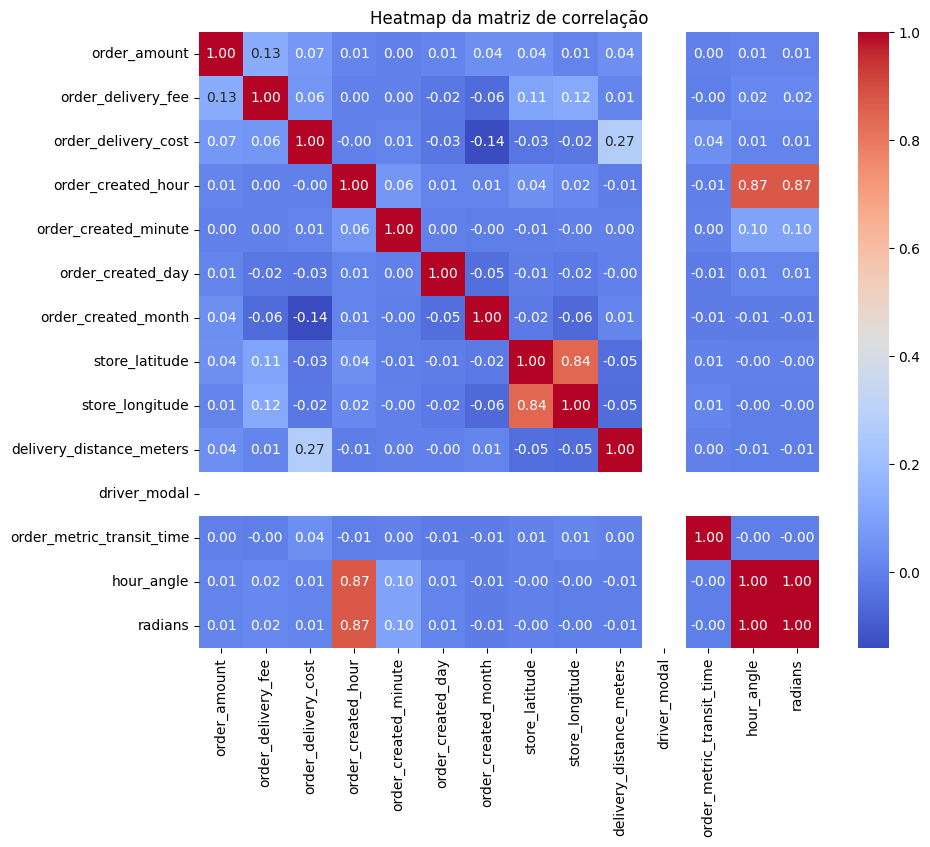

In [31]:
def modal(x):
    if x == 'BIKER':
        return 0
    else:
        return 1

plt.figure(figsize=(10, 8))  # Tamanho da figura

df_transito['driver_modal'] = df_transito['driver_modal'].apply(lambda x: modal(x))

# Substitua df pelo seu DataFrame
sns.heatmap(df_transito.corr(), annot=True, cmap='coolwarm', fmt=".2f")

# Adicione um título
plt.title('Heatmap da matriz de correlação')

# Exiba o plot
plt.show()

In [283]:
nomes_colunas_numericas = df_transito.select_dtypes(exclude=['object','datetime']).columns

for coluna in nomes_colunas_numericas:
    data1 = df_transito[coluna]
    data2 = df_transito['order_metric_transit_time']

    t_statistic, p_value = ttest_ind(data1, data2)

    print("\n")
    print(coluna)
    print("Estatística t:", t_statistic)
    print("Valor p:", p_value)



order_amount
Estatística t: 20.968226145370654
Valor p: 1.393494126237234e-97


order_delivery_fee
Estatística t: -27.26892004358578
Valor p: 1.2651106803235479e-163


order_delivery_cost
Estatística t: -26.29814464561619
Valor p: 2.486392208599808e-152


order_created_hour
Estatística t: -21.08717226092834
Valor p: 1.1383203294220008e-98


order_created_minute
Estatística t: -14.217466119871334
Valor p: 7.269876904938415e-46


order_created_day
Estatística t: -21.521412777869788
Valor p: 1.0787595034181232e-102


order_created_month
Estatística t: -28.785224350565432
Valor p: 4.443770024771279e-182


store_latitude
Estatística t: -43.418823489360825
Valor p: 0.0


store_longitude
Estatística t: -55.38680093206542
Valor p: 0.0


delivery_distance_meters
Estatística t: 94.68532486699895
Valor p: 0.0


order_metric_transit_time
Estatística t: 0.0
Valor p: 1.0


hour_angle
Estatística t: 73.99151317035255
Valor p: 0.0


radians
Estatística t: -28.42329007833424
Valor p: 1.38979912378332

In [39]:
df_transito.head()

,driver_modal,order_metric_transit_time
0,1,3.0
1,1,17.0
2,1,42.0
3,1,22.0
4,1,15.0


In [40]:
# df_transito = df_transito.drop(columns=['order_created_hour','order_created_minute','order_created_day','order_created_month','store_latitude','store_longitude'])
df.reset_index(drop=True, inplace=True)
df_transito = df_transito[['driver_modal', 'order_metric_transit_time']]

df_transito.head()


,driver_modal,order_metric_transit_time
0,1,3.0
1,1,17.0
2,1,42.0
3,1,22.0
4,1,15.0


Data Prep

In [41]:
# Transformando colunas categóricas em colunas numéricas
from sklearn.metrics import r2_score
def modal(x):
    if x == 'BIKER':
        return 0
    else:
        return 1

df_transito['driver_modal'] = df_transito['driver_modal'].apply(lambda x: modal(x))

print(df_transito.columns)

def cat_var(tab, x):
    if x == 0:
        cat = [i for i in tab.columns if tab.dtypes[i] == 'object']
    if x == 1:
        cat = [i for i in tab.columns if (tab.dtypes[i] == 'float64' or tab.dtypes[i] == 'int64')]
    return cat

def preparacao(tab):
    dados = tab.copy()
    order_metric_transit_time = dados.pop("order_metric_transit_time")
    return dados, order_metric_transit_time

tam_div = round(0.8 * len(df_transito)) # Tamanho da separação
tab_treino = df_transito.iloc[:tam_div] # Definindo parte a ser utilizada para treino
tab_valid = df_transito.iloc[tam_div:] # Definindo parte a ser utilizada para verificação

# Dados
X_treino = preparacao(tab_treino)[0]
X_valid = preparacao(tab_valid)[0]

Y_treino = preparacao(tab_treino)[1]
Y_valid = preparacao(tab_valid)[1]

# Modelo KNN
# numK = 1300 # Valor de K
# modelo = KNeighborsRegressor(n_neighbors=numK)

#LinearRegression
modelo = LinearRegression()

modelo.fit(X_treino, Y_treino) # Treinando o regressor
Y_prev_valid = modelo.predict(X_valid) # Prevendo os valores

# Calcular o MSE
mse = mean_squared_error(Y_valid, Y_prev_valid)
print('MSE:', mse) # Exibindo o MSE

r2 = r2_score(Y_valid, Y_prev_valid)
print('R²:', r2) # Exibindo o R²


Index(['driver_modal', 'order_metric_transit_time'], dtype='object')
MSE: 498767.99285853
R²: -1.4362533207190609e-06


In [51]:

tamanho = len(Y_valid)
lista = [median] * tamanho


print(Y_prev_valid)

mse = mean_squared_error(lista, Y_valid)
print('MSE:', mse) # Exibindo o MSE

[41.69775928 41.69775928 41.69775928 ... 41.69775928 41.69775928
 41.69775928]
MSE: 498767.48431295546


In [34]:
print(df_transito['order_metric_transit_time'])

0           3.0
1          17.0
2          42.0
3          22.0
4          15.0
          ...  
287453     13.0
287454     16.0
287456    509.0
287457    124.0
287458     13.0
Name: order_metric_transit_time, Length: 229168, dtype: float64


In [37]:
print(X_valid.columns)

Index(['driver_modal'], dtype='object')


In [220]:
print(Y_prev_valid)

[ 17.99579832  17.99579832  25.13445378 ...  24.68907563  31.72268908
 295.49159664]


# Modelo Final

Agora que todos os order_metric já tem seus modelos agora é necessária a junção de todos.

Funções preparações:

Como cada modelo utilizou de colunas diferente e meios diferentes, para prever em um novo dataframe essas funções serão criadas para facilitar o processo de dataprep

In [ ]:
def predict(df, modelo):
    X_prev = preparacao(df)[0]

    # Modelo KNN
    numK = round(np.sqrt(len(df_transito)) / 2) # Valor de K

    Y_prev_valid = modelo.predict(X_prev) # Prevendo os valores

    return Y_prev_valid

In [ ]:
#Transit_time

def prep_transito(df, modelo):
    colunas_transito = ['order_amount','order_delivery_fee','order_delivery_cost','order_created_hour', 'order_created_minute', 'order_created_day','order_created_month','store_latitude', 'store_longitude', 'hub_city','delivery_distance_meters', 'driver_modal','driver_type','order_metric_transit_time']
    df_transito = df[colunas_transito]

    df_transito['order_delivery_cost'] = df_transito['order_delivery_cost'].fillna(0.0)
    df_transito = df_transito.dropna(subset=['delivery_distance_meters','store_latitude','store_longitude','order_metric_transit_time'])

    df_transito['hour_angle'] = (df_transito['order_created_hour'] % 12) * 30 + (df_transito['order_created_minute'] / 60) * 30
    # Normalizando os ângulos para o intervalo [0, 360)
    df_transito['hour_angle'] = df_transito['hour_angle'] % 360
    df_transito['radians'] = np.radians(df_transito['hour_angle'])

    df_transito = df_transito.drop(columns=['driver_type'])
    df_transito = df_transito.drop(columns=['hub_city'])

    df_transito['driver_modal'] = df_transito['driver_modal'].apply(lambda x: modal(x))

    # Previsao

    Y_prev_valid = predict(df_transito,modelo)
    

    return Y_prev_valid

analise de cada coluna

outliers

In [252]:
def calcula_outliers(column):
    q1 = column.quantile(0.25)
    q3 = column.quantile(0.75)
    diff = q3 - q1
    lim_inf = q1 - 1.5 * diff
    lim_sup = q3 + 1.5 * diff
    outliers = column[(column < lim_inf) | (column > lim_sup)] # Definição de outliers pelos percentis e limites
    return outliers, lim_inf, lim_sup

# Função para contar outliers e calcular a porcentagem
def conta_outliers(df):
    outlier_info = pd.DataFrame(columns=['Coluna', 'Outliers', 'Porcentagem', 'lim_inf', 'lim_sup']) # Criando um novo DataFrame
    for col in df.select_dtypes(include=['int', 'float']): # Loop para verificar cada coluna numérica
        outliers, lim_inf, lim_sup = calcula_outliers(df[col]) # Chamando a função para calcular outliers
        outlier_count = len(outliers) # Verificando o tamanho da lista
        percentage = (outlier_count / len(df)) * 100 # Porcentagem de outliers
        outlier_info.loc[len(outlier_info)] = [col, outlier_count, percentage, lim_inf, lim_sup] # Atribuindo valores usando .loc[]
    return outlier_info # Retornando DataFrame

outlier_df = conta_outliers(df)
print(outlier_df)

                               Coluna  Outliers  Porcentagem       lim_inf  \
0                            order_id         0     0.000000  5.882139e+07   
1                        order_amount     11639     5.033495 -7.450000e+01   
2                  order_delivery_fee        64     0.027678 -1.650000e+01   
3                 order_delivery_cost      9065     3.920322  5.000000e-01   
4                  order_created_hour     20224     8.746232  4.500000e+00   
5                order_created_minute         0     0.000000 -3.100000e+01   
6                   order_created_day         0     0.000000 -1.350000e+01   
7                 order_created_month         0     0.000000 -1.000000e+00   
8         order_metric_collected_time     14631     6.327439 -3.000000e+00   
9            order_metric_paused_time     20141     8.710337 -5.000000e+00   
10       order_metric_production_time      9071     3.922917 -9.000000e+00   
11          order_metric_walking_time     10851     4.692710 -2.

heatmap

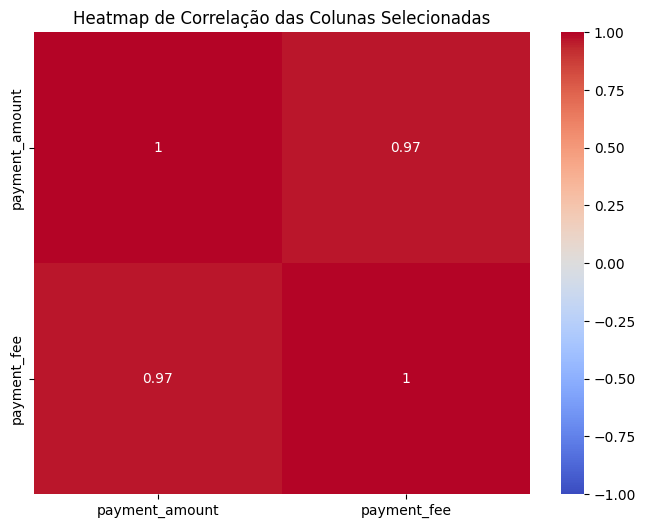

In [16]:
#Análise colunas midiáticas

colunas = ['payment_amount','payment_fee']
df_subset = df[colunas]

# Criar o heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df_subset.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap de Correlação das Colunas Selecionadas')
plt.show()

Muito correlacionado, utilizar apenas um no modelo ESCOLHER QUAL

In [256]:
df = df.drop(columns='payment_fee')

In [257]:
# Selecionando apenas as colunas numéricas do DataFrame
numeric_columns = df.select_dtypes(include=['int', 'float'])

# Exibindo as colunas numéricas
print(numeric_columns)


        order_id  order_amount  order_delivery_fee  order_delivery_cost  \
0       89066010            64                   6                  5.0   
1       74452603            74                  11                  6.0   
2       78635930            82                   9                  8.0   
3       70338727            85                   9                  8.0   
4       68874888           107                  11                  6.0   
...          ...           ...                 ...                  ...   
287453  85008042            75                   0                  9.0   
287454  86909485            26                   0                  5.0   
287456  88807164            52                   6                  0.0   
287457  88616043            23                   0                  0.0   
287458  77819085            74                   1                  8.0   

        order_created_hour  order_created_minute  order_created_day  \
0                       15  

In [259]:
def cat_var(tab, x):
  if x == 0:
    cat = [i for i in tab.columns if tab.dtypes[i] == 'object']
  if x == 1:
    cat = [i for i in tab.columns if (tab.dtypes[i] == 'float64' or tab.dtypes[i] == 'int64')]
  return cat

In [261]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

In [262]:
# Seleciona apenas as colunas que não são do tipo 'object'
numeric_columns = df.select_dtypes(exclude=['object'])

# Cria um novo DataFrame apenas com as colunas numéricas
new_df = df[numeric_columns.columns]

In [270]:
# Suponha que df é o seu DataFrame com as colunas necessárias
def treino(df):
    # Passo 1: Divida o DataFrame em X e y
    X,Y = preparacao(df)

    print(df)

    # Passo 2: Divida os dados em conjuntos de treinamento e teste
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    # Passo 3: Importe o modelo de regressão linear
    model = LinearRegression()

    # Passo 4: Ajuste o modelo aos dados de treinamento
    model.fit(X_train, y_train)

    # Passo 5: Faça previsões usando os dados de teste
    y_pred = model.predict(X_test)

    # Passo 6: Calcule o MSE
    mse = mean_squared_error(y_test, y_pred)
    print("Mean Squared Error:", mse)

    # Exemplo de uso:
    rmse_value = rmse(y_test, y_pred)
    print("RMSE:", rmse_value)